**Imports**

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import saraRC1 as sara
from time import time

import scipy.stats as sc

seg_dim = 8

**Functions**

In [31]:
T = 0.001

def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

def mae(pred, gt):
    return np.mean(np.abs(pred - gt))

experiment_results = {}

**MASK R-CNN**

In [24]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")


class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


import tensorflow as tf
import keras
import h5py
print(tf.__version__)
print(keras.__version__)
print(h5py.__version__)

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matthewkenely/anaconda3/e


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

**DeepGaze**

In [28]:
import deepgaze_pytorch
DEVICE = 'cuda'
deepgaze = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

Loaded pretrained weights for efficientnet-b5


Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0


**Results**

In [23]:
# Create results.csv
if not os.path.exists('results.csv'):
    with open('results.csv', 'w') as f:
        f.write('Experiment,SOR,MAE\n')

**Experiments**

In [52]:
ranges = list(zip(np.arange(1, 7000, 100), np.arange(100, 7100, 100)))
ranges = [list(t) for t in ranges]
ranges[0][0] = 0
ranges[0][1] = 5

img_path = './Siris Dataset/ASSR/images/train/'

for experiment in range(1, 10):
    print('EXPERIMENT:', experiment)
    range_ = ranges[experiment - 1]
    imgs = {}
    i = 0

    ### IMAGES
    for root, dirs, files in os.walk(img_path):
        for file in files[range_[0]:range_[1]]:
            file_name = file.split('.')[0]
            imgs[file_name] = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
            i += 1


    ### MASKS
    mask_path = './Siris Dataset/ASSR/gt/train/'
    gt_masks = {}
    gt_ranks = {}

    for file_name in imgs:
        gt_ranks[file_name] = {}
        
        file = file_name + '.png'
        mask = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
        # masks[file_name] = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
        # Separate the mask based on colour
        # masks[file_name] = {}
        gt_masks[file_name] = {}

        # Detect different colours in mask
        # Create histogram
        hist = cv2.calcHist([mask], [0], None, [256], [0, 256])

        # Show non-zero values and extract intensity values at that freq
        non_zero = np.nonzero(hist)
        x = non_zero[0][1:]

        # Separate mask into regions which match the intensity values in x
        for i, intensity in enumerate(reversed(x)):
            # masks[file_name][i] = np.where(mask == intensity, 1, 0)
            gt_masks[file_name][i] = np.where(mask == intensity, 1, 0)
            
            # Calculate ranks based on highest intensity
            gt_ranks[file_name][i] = i + 1

    # masks = gt_masks # To be replaced with MASK R-CNN
    masks = {}

    for file_name in imgs:
        # Run detection
        results = model.detect([imgs[file_name]], verbose=1)

        masks[file_name] = {}
        
        for i in range(len(results[0]['class_ids'])):
            masks[file_name][i] = np.array(results[0]['masks'][:, :, i], dtype=np.uint8) * 255

    # Match masks generated to Mask RCNN to ground truth masks
    masks_valid = {}
    gt_masks_valid = {}
    gt_ranks_valid = {}

    for file_name in masks:
        masks_valid[file_name] = {}
        gt_masks_valid[file_name] = {}
        gt_ranks_valid[file_name] = {}
        
        for mask in masks[file_name]:
            best_iou = 0
            for gt_mask in gt_masks[file_name]:
                # Calculate IoU
                intersection = np.logical_and(masks[file_name][mask], gt_masks[file_name][gt_mask])
                union = np.logical_or(masks[file_name][mask], gt_masks[file_name][gt_mask])
                iou_score = np.sum(intersection) / np.sum(union)

                if iou_score > 0.5 and iou_score > best_iou:
                    best_iou = iou_score
                    masks_valid[file_name][mask] = masks[file_name][mask]
                    gt_masks_valid[file_name][mask] = gt_masks[file_name][gt_mask]
                    gt_ranks_valid[file_name][mask] = gt_ranks[file_name][gt_mask]

            # fig, ax = plt.subplots(1, 2, figsize=(10, 10))
            # ax[0].imshow(masks_valid[file_name][mask], cmap='gray')
            # ax[1].imshow(gt_masks_valid[file_name][mask], cmap='gray')
            # plt.show()

    masks = masks_valid
    gt_masks = gt_masks_valid
    gt_ranks = gt_ranks_valid

    
    ### GENERATE SALIENCY MAPS, HEATMAPS, RANKINGS
    saliency_maps = {}
    sara_heatmaps = {}
    sara_lists = {}

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.figure()
    plt.tight_layout()

    # generators = ['itti', 'deepgaze', 'fpn', 'emlnet']
    generators = ['deepgaze']

    g = 1

    for i, im in enumerate(imgs):
        start = time()

        if im not in saliency_maps:
            saliency_maps[im] = {}
            sara_heatmaps[im] = {}
            sara_lists[im] = {}

        for generator in generators:
            percent = round(g/(len(imgs)*len(generators))*100, 2)
            
            print(f'--> Processing image {i+1} of {len(imgs)} ({generator}) [{percent}%]')

            saliency_maps[im][generator] = sara.return_saliency(imgs[im].copy(), generator=generator, deepgaze_model=deepgaze)
            sara.reset()

            sara_heatmaps[im][generator], sara_lists[im][generator] = sara.return_sara(imgs[im].copy(), seg_dim, saliency_map=saliency_maps[im][generator])
            sara.reset()

            g += 1
        
        print(f'Time for image {i + 1}: {time() - start} seconds')

    ### MASK RANKING
    # For each segment, check which mask falls under that segment using MRn = rank(Gi); (Gi interesect Mn) > T
    mask_segments = {}

    for sara_list in sara_lists:
        for segment in sara_lists[sara_list]['deepgaze']:
            if sara_list not in mask_segments:
                mask_segments[sara_list] = {}

            # Convert index to coordinates, extract segment from heatmap
            shape = sara_heatmaps[sara_list]['deepgaze'].shape[0:2]
            x1, y1, x2, y2 = index_to_coordinates(segment[5], seg_dim, shape)
            # print(x1, y1, x2, y2)

            for m in masks[sara_list]:
                if m not in mask_segments[sara_list]:
                    mask_segments[sara_list][m] = []

                # Extract mask from masks
                mask = masks[sara_list][m][y1:y2, x1:x2]

                # Calculate intersection over union
                intersection = np.sum(mask > 0)
                union = np.sum(mask > 0) + np.sum(mask == 0)

                iou = intersection / union

                # print('Segment: ', segment[5], 'Mask: ', m, 'IoU: ', iou)

                if iou > T:
                    # index, rank, saliency
                    # print(segment)
                    mask_segments[sara_list][m].append((segment[5], segment[0], segment[1]))
                    # print(mask_segments)

    # For each mask, find the segment with the lowest rank
    mask_segments_min = {}

    for sara_list in mask_segments:
        for m in mask_segments[sara_list]:
            # mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])[0]
            if sara_list not in mask_segments_min:
                mask_segments_min[sara_list] = {}
            
            mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])

    mask_segments_min

    mask_ranks = {}

    for sara_list in mask_segments_min:
        mask_ranks[sara_list] = {}
        # Extract the ranks and sort them by the third value in each tuple
        sorted_ranks = sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][1])

        for i in range(len(sorted_ranks)):
            mask_ranks[sara_list][sorted_ranks[i][0]] = i + 1

        # Sort mask_ranks[sara_list] by object
        mask_ranks[sara_list] = {k: v for k, v in sorted(mask_ranks[sara_list].items(), key=lambda item: item[0])}


    ### SOR
    all_spr = 0

    for sara_list in mask_ranks:
        print(f'PR: {list(mask_ranks[sara_list].values())}\nGT: {list(gt_ranks[sara_list].values())}')
        try:
            spr = sc.spearmanr(list(mask_ranks[sara_list].values()), list(gt_ranks[sara_list].values()))
            all_spr += spr.correlation
        except:
            pass
        print()

    print(f'Average SPR: {all_spr / len(mask_ranks)}')

    all_mae = 0

    for sara_list in masks:
        for mask in masks[sara_list]:
            # print(masks[sara_list][mask] - gt_masks[sara_list][mask])
            pred = masks[sara_list][mask]
            pred = np.array(pred, dtype=np.uint8)
            pred = cv2.threshold(pred, 0.5, 1, cv2.THRESH_BINARY)[1]

            gt = gt_masks[sara_list][mask]
            gt = np.array(gt, dtype=np.uint8)
            gt = cv2.threshold(gt, 0.5, 1, cv2.THRESH_BINARY)[1]

            temp_mae = mae(pred, gt)
            # plt.figure()
            # plt.subplot(131)
            # plt.imshow(pred)
            # plt.subplot(132)
            # plt.imshow(gt)
            # plt.subplot(133)
            # plt.imshow(pred - gt)
            all_mae += temp_mae
            # print()
            break

    print(f'Average /mae: {all_mae / len(masks)}')

    experiment_results[experiment] = {}
    experiment_results[experiment]['SOR'] = all_spr / len(mask_ranks)
    experiment_results[experiment]['MAE'] = all_mae / len(masks)

    # Append to results.csv
    with open('results.csv', 'a') as f:
        f.write(f'{experiment},{experiment_results[experiment]["SOR"]},{experiment_results[experiment]["MAE"]}\n')
    

EXPERIMENT: 1
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.7000

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

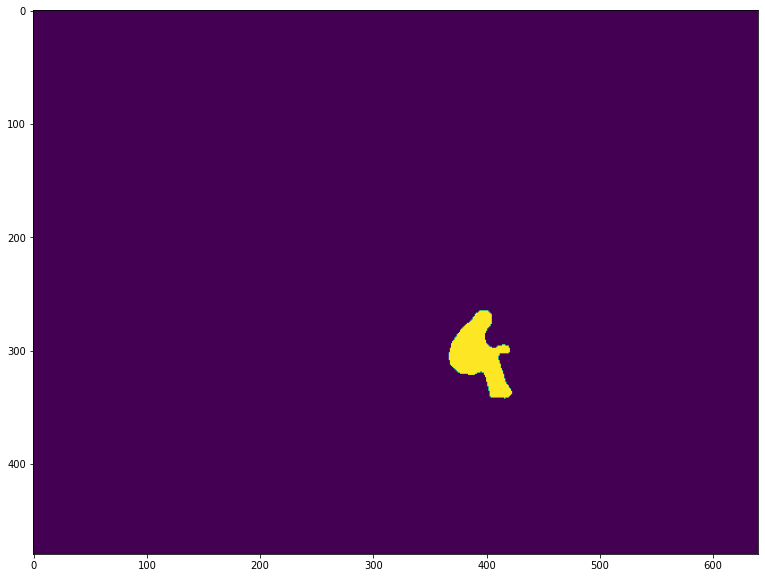

In [50]:
plt.imshow(masks_valid[list(masks_valid.keys())[0]][0])

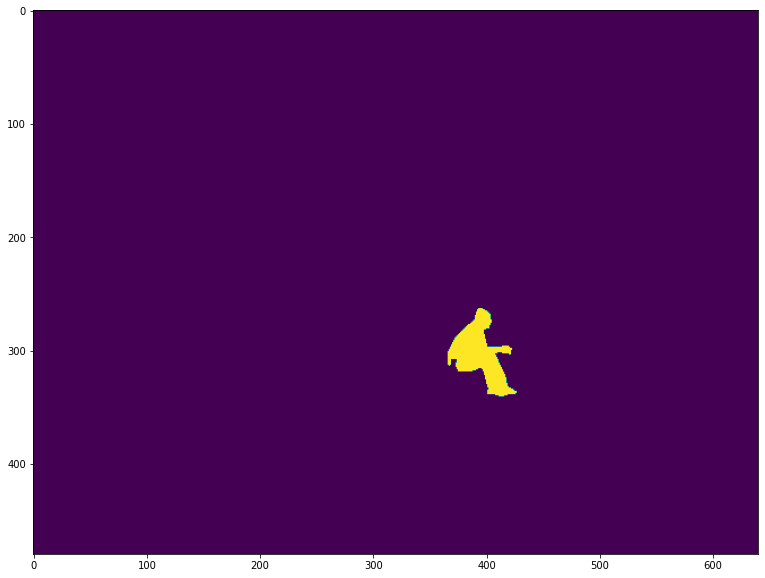

In [51]:
plt.imshow(gt_masks_valid[list(gt_masks_valid.keys())[0]][0])